- In a typical data science project we try several models like (logistic regression, SVM, tree-classifiers etc) on our data.
- Then we measure the predicting performance of these models to find the best performing one.
- Finally we decide to implement the best performing model.
- In this notebook we talk about one of the classification model evaluation tools: Confusion matrix.

- They can help us to see deeper how much reliable our models are.

- We are going to look at the confusion matrices of a variety of Scikit-Learn models and compare them using visual diagnostic tools from Yellowbrick in order to select the best model for our data.

![thisway](/images/thisway.jpg)

<!-- TEASER_END -->

In [4]:
# Notebook setup
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

import category_encoders as ce
from yellowbrick.classifier import ConfusionMatrix

import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline

## Confusion Matrix


- Since we know the labels of the test set we can measure how succesfull are the predictions of the model by comparing the the **actual labels** and **predictions**

- We can see if our classifier identifies the samples succesfully, or it is **"CONFUSED"** with another label? 
- Confusion matrix shows the amount of confusion. 
- We use confusion matrices to understand **which classes are most easily confused**

- There are two sets of labels in a confusion matrix of **binary (2 class) classification**:
    - `{POSITIVE, NEGATIVE}`- first, the model makes the prediction. It returns the labels 1 (POSITIVE) or 0 (NEGATIVE). 
    - `{TRUE, FALSE}`- then the model's prediction is evaluated if the prediction is made correctly (TRUE) or incorrectly (FALSE) based on the actual known labels.
    
    
- **Tip:** If you have difficulty to remember these terms because of the similarity of the terms just insert the word `"PREDICTED"` in the middle. 
- For instance  if you are confused with the meaning of `"false positive"` read it like `"false(ly) PREDICTED positive"`

![confusion1](/images/confusion1.jpg)
- We create a matrix of predictions and actual labels for a binary classification. 
- One diagonal show the succesful predictions the other diagonal unsuccessful predictions

- In multi-class classification ie if the class labels are more than 2  (not 1 or 0, positive or negative), the confusion matrix looks like something like this

![confusion2](/images/confusion2.jpg)

- We do not use the terms like "true positive" with the confusion matrix with classes more than 2
- The size of the confusion matrix is $nxn$ where $n$ is the number of classes
- Different references may use a different convention for axes ie actual and predicted classes can take place on different axes

### Examples of confusion matrices
- Lets demonstrate some confusion matrices
- We will utilize the tools from [yellowbrick library](http://www.scikit-yb.org/en/latest/api/classifier/confusion_matrix.html). This is a nice library for machine learning visualization.

### Loading and Exploring the Dataset
- This tutorial uses a **modified version** of the `mushroom` dataset from the **UCI Machine Learning Repository**.
- Even though these toy datasets are not interesting anymore because of repetitive usage, here our focus is the classification metrics not other steps of data processing. So we try to get the advantage of fast implementation of this dataset 
- Our objective is to predict if a mushroom is **poisonous** or **edible** based on its characteristics.
- The data include descriptions of hypothetical samples corresponding to **23 species of mushrooms**  
- Each species was identified as definitely **edible** or **poisonous**

In [5]:
# Url of the dataset
url='https://raw.githubusercontent.com/rebeccabilbro/rebeccabilbro.github.io/master/data/agaricus-lepiota.txt'
# Column names list
column_names=['class', 'cap-shape', 'cap-surface', 'cap-color']
# Load the data
mushrooms=pd.read_csv(url, header=None, names= column_names)

mushrooms.head(3)

class cap-shape cap-surface cap-color
0     edible    convex      smooth    yellow
1     edible      bell      smooth     white
2  poisonous    convex       scaly     white

In [6]:
mushrooms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8123 entries, 0 to 8122
Data columns (total 4 columns):
class          8123 non-null object
cap-shape      8123 non-null object
cap-surface    8123 non-null object
cap-color      8123 non-null object
dtypes: object(4)
memory usage: 253.9+ KB


In [7]:
## Count the unique values in each column
mushrooms.nunique()

class           2
cap-shape       6
cap-surface     4
cap-color      10
dtype: int64

- We see that target and feature columns contain different categorical values.
- We need to encode them into numerical types in order to fit Sklearn models. 
- For this purpose, we will utilize [Category Encoders](http://contrib.scikit-learn.org/categorical-encoding/index.html)
library which provides scikit-learn-compatible categorical variable encoders. 
- All the transformers of **Category Encoders** can be used in Sklearn pipelines.
- Later in a separate post we will analyse the encoders

### Target and Features Datasets

In [8]:
# Create the features dataset (X) and target dataset (y)
features = ['cap-shape', 'cap-surface', 'cap-color']
target   = 'class'

X = mushrooms[features]
y = mushrooms[target]

### Classifiers Dictionary
- Now, tet's create a dictionary which contains the classifiers we want to use for our classification task
- Here we create the dictionary with instantiates of Sklearn estimators **without hyperparameter tuning**. 
- In reality we need to evaluate the performance of tuned classifiers.

In [10]:
# Estimators dictionary
# We can add as more classifiers to our dictionary
# This is just a sample
estimators_dct={"Logistic Legression": LogisticRegression(),
                "Linear SVC" : LinearSVC(),
                "Random Forest": RandomForestClassifier(n_estimators=8),
                "SGD Classifier": SGDClassifier(),
               }

## confusion_matrices function 
- Let's define a function to get the confusion matrices of a given dictionary of models (like in the upper cell) easily without repetion.



- Our function will
    - take **X, y datasets** and an **estimator dictionary** 
    - return the confusion matrices produced by the predictions of each model in the dictionary

In [9]:
# set up the figure size for the confusion matrices
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 15

def confusion_matrices(X, y, estimator_dict):
    """
    Takes X, y datasets and an estimator dictionary -> returns confusion matrices of the classifiers
    """
    # Split the data as train and test
    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=11)
    
    # Loop over the estimator_dict keys to get the each estimator 
    for estimator in estimator_dict.keys():
        print(estimator)
        
        # In the pipeline we use OneHotEncoder from Category Encoders
        model = Pipeline([('encoder', ce.OneHotEncoder()),
                          ('estimator', estimator_dict[estimator])])
        
        # Instantiate the classification model and visualizer
        model.fit(X_train, y_train)
        
        # The ConfusionMatrix visualizer takes a model
        cm = ConfusionMatrix(model, fontsize=13, cmap='YlOrBr')
        
        # To create the ConfusionMatrix, we need some test data
        # Score runs predict() on the data and then 
        # creates the confusion_matrix from scikit-learn
        cm.score(X_test, y_test)
        
        cm.poof()

Logistic Legression


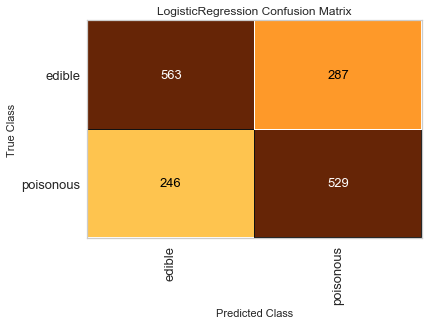

Linear SVC


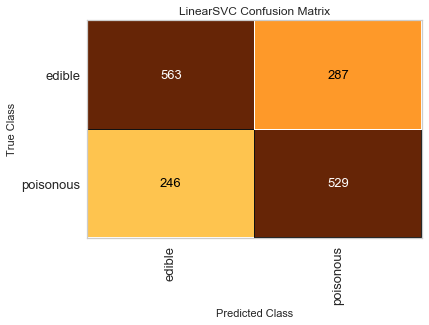

Random Forest


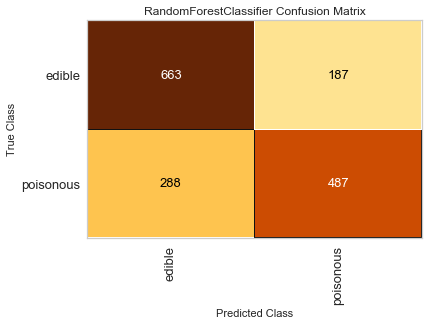

SGD Classifier


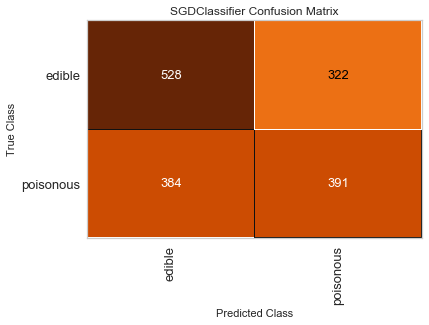

In [11]:
# Call the confusion_matrices function to get the confusion matrices
confusion_matrices(X, y, estimators_dct)

### ConfusionMatrix  from Yellowbrick

- takes a **fitted scikit-learn classifier** and a set of `X_test` and `y_test` values and 
- returns a report showing how each of the test samples predicted classes compare to their actual classes. 

- Confusion matrices provide similar information as what is available in a `ClassificationReport` (we will talk about it soon), but rather than top-level scores, they provide deeper insight into the classification of individual data points.

- Creates a heatmap visualization of the `sklearn.metrics.confusion_matrix()`. 
-  We can choose between displaying values as the percent of true (cell value divided by sum of row) or as direct counts. 

## Conclusion
- Even though we can get deeper insight on predictions of the classifiers by confusion matrices, still it is not very practical to compare several models performance with each other

- Since confusion matrices provides tables of actual and prediction comparision we still need some more metrics to interpret the result more directly to choose the best model

- So we will continue to work on classification metrics like **precision, recall, roc, auc** etc in the next posts

Sources:
- http://www.scikit-yb.org/en/latest/api/classifier/confusion_matrix.html
- http://contrib.scikit-learn.org/categorical-encoding/index.html